In [1]:
import os
import numpy as np
import tensorflow as tf
import random
import matplotlib.pyplot as plt
import sionna as sn
from scipy.special import erfc
import pandas as pd
import seaborn as sns
import optuna

sns.set(style="whitegrid")

2025-06-06 17:10:32.041581: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-06-06 17:10:32.051950: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1749247832.064925 1834714 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1749247832.068187 1834714 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1749247832.077285 1834714 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking 

In [2]:
# --- Utility functions ---
def compute_bler(block_size, ber):
    errors = np.random.rand(10, block_size) < ber
    # any error in a packet ⇒ that packet is lost
    block_losses = np.any(errors, axis=1)
    # BLER estimate = fraction of lost packets
    return float(block_losses.mean())

def compute_ber_bler(tx_bits, rx_bits):
    ber  = np.mean(tx_bits != rx_bits)
    bler = float(np.any(tx_bits != rx_bits))
    return ber, bler

def transmit(bits, ber):
    errors = np.random.rand(len(bits)) < ber
    return np.bitwise_xor(bits, errors.astype(np.uint8))

def ber_theoretical(snr_linear, modulation):
    modulation = modulation.lower()
    if modulation == "bpsk" or modulation == "qpsk":
        # Q(x) = 0.5 * erfc(x / sqrt(2))
        return 0.5 * erfc(np.sqrt(2 * snr_linear) / np.sqrt(2))
    elif modulation == "16qam":
        M = 16
        factor = (4 / np.log2(M)) * (1 - 1 / np.sqrt(M))
        argument = np.sqrt( (3 * np.log2(M) / (M - 1)) * snr_linear )
        return factor * 0.5 * erfc(argument / np.sqrt(2))
    elif modulation == "64qam":
        M = 64
        factor = (4 / np.log2(M)) * (1 - 1 / np.sqrt(M))
        argument = np.sqrt( (3 * np.log2(M) / (M - 1)) * snr_linear )
        return factor * 0.5 * erfc(argument / np.sqrt(2))
    elif modulation == "256qam":
        M = 256
        factor = (4 / np.log2(M)) * (1 - 1 / np.sqrt(M))
        argument = np.sqrt( (3 * np.log2(M) / (M - 1)) * snr_linear )
        return factor * 0.5 * erfc(argument / np.sqrt(2))
    else:
        raise ValueError("Unsupported modulation: choose from 'bpsk', 'qpsk', '16qam', or '64qam'.")


# --- SatUTDesertEnvSionna class ---
class SatUTDesertEnvSionna:
    def __init__(self, ut_positions, ut_gains=None, seed=None):

        if ut_gains is None:
            # If not provided, use default gain for all UTs
            ut_gains = np.full((ut_positions.shape[0],), 2.0)
        self.ut_gains = ut_gains
        
        # SAT↔UAV
        self.tx_power_sat = 40 # dBm  
        self.sat_gain = 30.0 # dBi
        self.uav_gain_sat = 10.0 # dBi (for SAT↔UAV)
        self.system_loss_sat = 0 # dB
        self.extra_losses_sat = 10.0 # dB
        self.alt_sat = 600e3 # m

        # UAV↔UT
        self.uav_gain = 10 # dBi (omni)
        self.tx_power_uav = 30.0 # dBm
        self.system_loss_uav = 0 # dB
        self.alt_ut = 1.5 # m

        # System parameters
        self.fc = 2e9             # Hz
        self.bandwidth = 1.92e6   # Hz
        self.noise_figure = 5.0   # dB

        # Transmit powers & antenna gains
        self.sat_gain_down = 30.0 # dBi
        self.tx_power_ut = 23.0   # dBm
        self.sat_gain_up = 30.0   # dBi

        # Losses & altitudes
        self.system_loss = 2 # dB -> polarization loss 
        self.extra_losses = 0   # dB (desert)
        self.alt_sat = 600e3      # m
        self.alt_ut = 1.5         # m

        # OFDM parameters
        self.num_ofdm_symbols     = 14
        self.fft_size             = 128
        self.subcarrier_spacing   = 15e3
        self.cyclic_prefix_length = 16
        self.num_tx               = 1
        self.num_streams_per_tx   = 1

        # UT positions (add altitude if needed)
        self.ut_positions = np.array(ut_positions)
        if self.ut_positions.shape[1] == 2:
            alt_col = np.full((self.ut_positions.shape[0],1), self.alt_ut)
            self.ut_positions = np.hstack([self.ut_positions, alt_col])

        # Sionna OFDM & channel
        self.rg         = sn.phy.ofdm.ResourceGrid(
            num_ofdm_symbols     = self.num_ofdm_symbols,
            fft_size             = self.fft_size,
            subcarrier_spacing   = self.subcarrier_spacing,
            num_tx               = self.num_tx,
            num_streams_per_tx   = self.num_streams_per_tx,
            cyclic_prefix_length = self.cyclic_prefix_length,
            pilot_pattern        = "kronecker",
            pilot_ofdm_symbol_indices = [2, 11]
        )
        self.rg_mapper  = sn.phy.ofdm.resource_grid.ResourceGridMapper(self.rg)
        self.awgn       = sn.phy.channel.awgn.AWGN()

        # constants & RNG
        self.c   = 3e8  # m/s
        self.rng = np.random.default_rng(seed)
        random.seed(seed)

    @staticmethod
    def fspl(fc, d, n=2):
        return 32.45 + 10*n*np.log10(d/1e3) + 20*np.log10(fc/1e6)

    @staticmethod
    def iono_scintillation_loss(fc_ghz, Pfluc_4ghz=2, elevation_deg=90):
        base = (fc_ghz / 4)**-1.5 * Pfluc_4ghz / (np.sqrt(2)*np.sin(np.radians(elevation_deg)))
        return max(0, base + np.random.normal(0,1))

    @staticmethod
    def atmos_loss(elevation_deg):
        base = 0.01/np.sin(np.radians(elevation_deg))
        return max(0, base + np.random.normal(0,0.005))

    # @staticmethod
    # def shadowing(sigma=3):
    #     return float(np.clip(np.random.normal(0,sigma), -2*sigma, 2*sigma))

    @staticmethod
    def shadowing(theta, scene):
        sigma_ranges = {
            "Desert":   (6.0, 2.0),
            "Mountain": (8.0, 4.0),
            "City":     (10.0, 6.0)
        }
        theta_min, theta_max = 5.0, 30.0
        sigma_max, sigma_min = sigma_ranges.get(scene, (10.0, 3.0))
        if theta <= theta_min:
            sigma = sigma_max
        elif theta >= theta_max:
            sigma = sigma_min
        else:
            frac = (theta - theta_min) / (theta_max - theta_min)
            sigma = sigma_max - frac * (sigma_max - sigma_min)
        return np.random.randn() * sigma
    
    @staticmethod
    def noise_floor(bw, nf):
        return -174 + 10*np.log10(bw) + nf

    @staticmethod
    def slant_range(alt_sat, alt_ut, horizontal_dist):
        return np.sqrt((alt_sat-alt_ut)**2 + horizontal_dist**2)

    @staticmethod
    def rayleigh_fading():
        return (np.random.normal(0,1)+1j*np.random.normal(0,1))/np.sqrt(2)

    @staticmethod
    def rician_fading(K=2):
        s     = np.sqrt(K/(K+1))
        sigma = np.sqrt(1/(2*(K+1)))
        return s + sigma*(np.random.normal(0,1)+1j*np.random.normal(0,1))
    
    

    def get_fading(self,theta, scene):
        if scene == "Desert":
            los_prob         = 0.90
            theta_thresh_deg = 15
            K_los            = 8
        elif scene == "Mountain":
            los_prob         = 0.60
            theta_thresh_deg = 20
            K_los            = 4
        elif scene == "Urban":
            los_prob         = 0.10
            theta_thresh_deg = 30
            K_los            = 1
        else:
            # Default fallback
            los_prob         = 0.20
            theta_thresh_deg = 20
            K_los            = 2
    
        if np.random.rand() < los_prob and theta > theta_thresh_deg:
            h = self.rician_fading(K=K_los)
        else:
            h = self.rayleigh_fading()
    
        return h
    
    
    def evaluate(self, direction="downlink", scene="Desert"):
        snrs = []
        area_size = 10e3
        sat_xy = np.array([area_size/2, area_size/2])
        for idx, ut_xyz in enumerate(self.ut_positions):
            horiz = np.linalg.norm(ut_xyz[:2]-sat_xy)
            d_slant = self.slant_range(self.alt_sat, self.alt_ut, horiz)
            elev = np.degrees(np.arctan2(self.alt_sat-self.alt_ut, horiz))

            loss_fspl = self.fspl(self.fc, d_slant)
            loss_iono = self.iono_scintillation_loss(self.fc/1e9, elevation_deg=elev)
            loss_atmo = self.atmos_loss(elev)
            loss_shad = self.shadowing(elev,scene)

            total_loss = loss_fspl + loss_iono + loss_atmo + loss_shad + \
                         self.system_loss #+ self.extra_losses
            noise = self.noise_floor(self.bandwidth, self.noise_figure)

            if direction=="downlink":
                rx_p = self.tx_power_sat + self.sat_gain_down + self.ut_gains[idx]- total_loss
            else:
                rx_p = self.tx_power_ut  + self.ut_gains[idx]   + self.sat_gain_up  - total_loss

            snr_db     = rx_p - noise
            snr_linear = 10**(snr_db/10)

            # fading
            h = self.get_fading(elev, scene)

            # OFDM signal+noise
            x = tf.complex(
                tf.random.uniform([1,self.num_tx,self.rg.num_data_symbols,self.num_streams_per_tx],-1,1),
                tf.random.uniform([1,self.num_tx,self.rg.num_data_symbols,self.num_streams_per_tx],-1,1)
            )
            x_rg = self.rg_mapper(x)
            x_f  = x_rg * h
            p_sig = np.mean(np.abs(x_f.numpy())**2)
            noise_var = p_sig/snr_linear
            y = self.awgn(x_f, noise_var)

            measured_snr = np.mean(np.abs(x_f.numpy())**2) / \
                           np.mean(np.abs((y-x_f).numpy())**2)
            snrs.append(measured_snr)
        return np.array(snrs)
    def evaluate_sagin(self, uav_xyz, direction="downlink", scene="Desert"):
        uav_xyz = np.array(uav_xyz)
        x, y, z = uav_xyz
        snrs_linear = []
        for idx, ut_xyz in enumerate(self.ut_positions):
            horizontal_dist = np.linalg.norm(uav_xyz[:2] - ut_xyz[:2])
            vertical_dist = z - ut_xyz[2]
            slant_dist = np.linalg.norm(uav_xyz - ut_xyz)

            # --- SAT↔UAV hop (NO atmospheric loss) ---
            elevation_sat_uav = self.rng.uniform(10, 90)
            d_slant = self.slant_range(self.alt_sat, z, elevation_sat_uav)
            fspl_sat = self.fspl(self.fc, d_slant, n=2)
            iono_sat = self.iono_scintillation_loss(self.fc/1e9, Pfluc_4ghz=2, elevation_deg=elevation_sat_uav)
            total_loss_sat = fspl_sat + iono_sat + self.system_loss_sat + self.extra_losses_sat

            v_rel = self.rng.uniform(-7500, 7500)
            f_doppler = (v_rel / self.c) * self.fc

            # --- UAV↔UT hop (desert, with minimal atmospheric loss) ---
            fspl_uav = self.fspl(self.fc, slant_dist, n=2)
            elevation_angle = np.degrees(np.arctan2(vertical_dist, horizontal_dist))
            atmos_uav = self.atmos_loss(elevation_angle)
            
            shadow = self.shadowing(elevation_angle, scene)
            unclipped_pl = fspl_uav + atmos_uav + shadow + self.system_loss_uav
            clipped_pl = max(unclipped_pl, 0)
            # Fading: Rician only (strong LOS)
            
            h = self.get_fading(elevation_angle, scene)            
            noise_sat = self.noise_floor(self.bandwidth, self.noise_figure)
            noise_uav = self.noise_floor(self.bandwidth, self.noise_figure)
            if direction == "downlink":
                rx_power_sat = self.tx_power_sat + self.sat_gain + self.uav_gain_sat - total_loss_sat
                snr_sat = rx_power_sat - noise_sat
                snr_sat_linear = 10**(snr_sat/10)
                rx_power_uav = self.tx_power_uav + self.uav_gain + self.ut_gains[idx] - clipped_pl
                snr_uav = rx_power_uav - noise_uav
                snr_uav_linear = 10**(snr_uav/10)
                snr_uav_linear *= abs(h)**2
                snr_bottleneck = min(snr_sat_linear, snr_uav_linear)
                snrs_linear.append(snr_uav_linear)
            elif direction == "uplink":
                rx_power_uav = self.tx_power_ut + self.uav_gain + self.ut_gains[idx] - clipped_pl
                snr_uav = rx_power_uav - noise_uav
                snr_uav_linear = 10**(snr_uav/10)
                rx_power_sat = self.tx_power_uav + self.sat_gain + self.uav_gain_sat - total_loss_sat
                snr_sat = rx_power_sat - noise_sat
                snr_sat_linear = 10**(snr_sat/10)
                snr_uav_linear *= abs(h)**2
                snr_bottleneck = min(snr_uav_linear, snr_sat_linear)
                
                snrs_linear.append(snr_uav_linear)
            else:
                raise ValueError("direction must be 'downlink' or 'uplink'")
        return np.array(snrs_linear)

0


I0000 00:00:1749247836.204690 1834714 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 14704 MB memory:  -> device: 0, name: NVIDIA RTX A4500, pci bus id: 0000:55:00.0, compute capability: 8.6
I0000 00:00:1749247836.206284 1834714 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 17760 MB memory:  -> device: 1, name: NVIDIA RTX A4500, pci bus id: 0000:a2:00.0, compute capability: 8.6


1
2
0
1
2
0
1
2


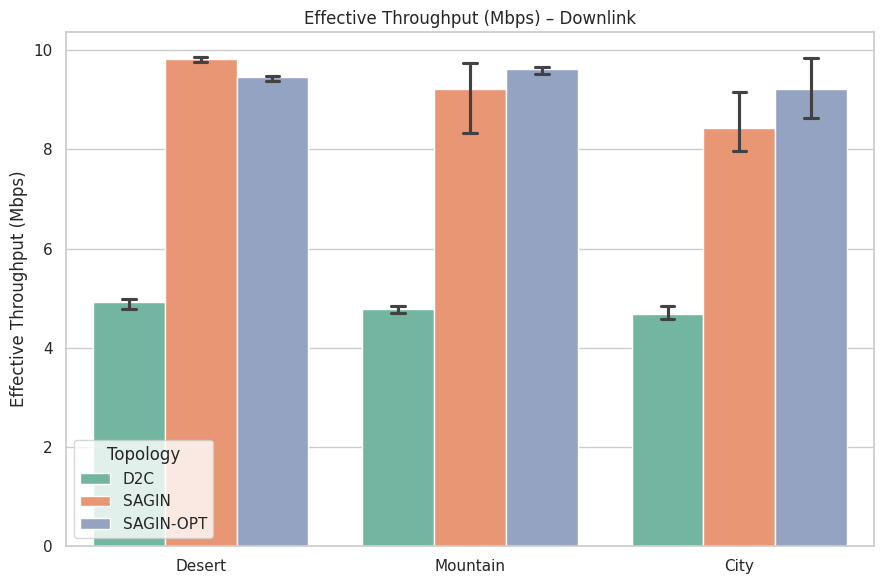

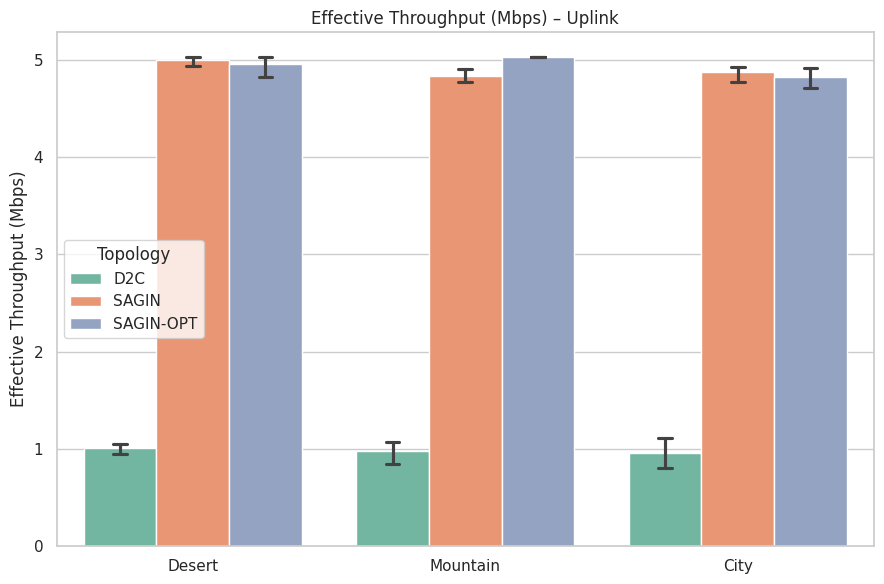

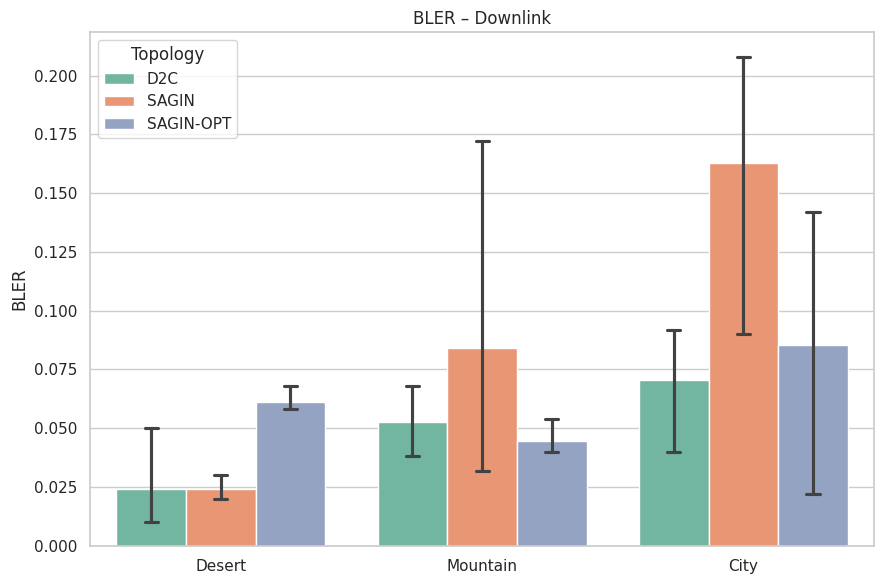

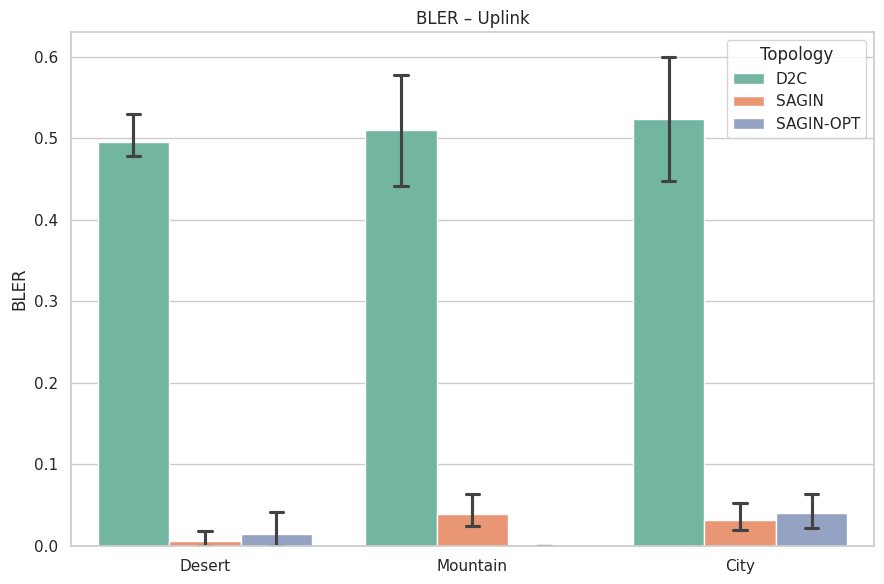

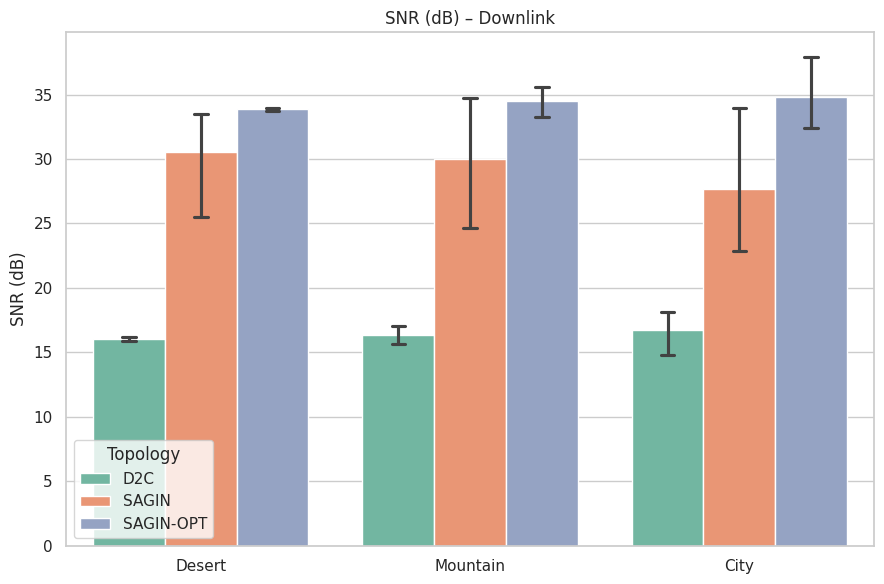

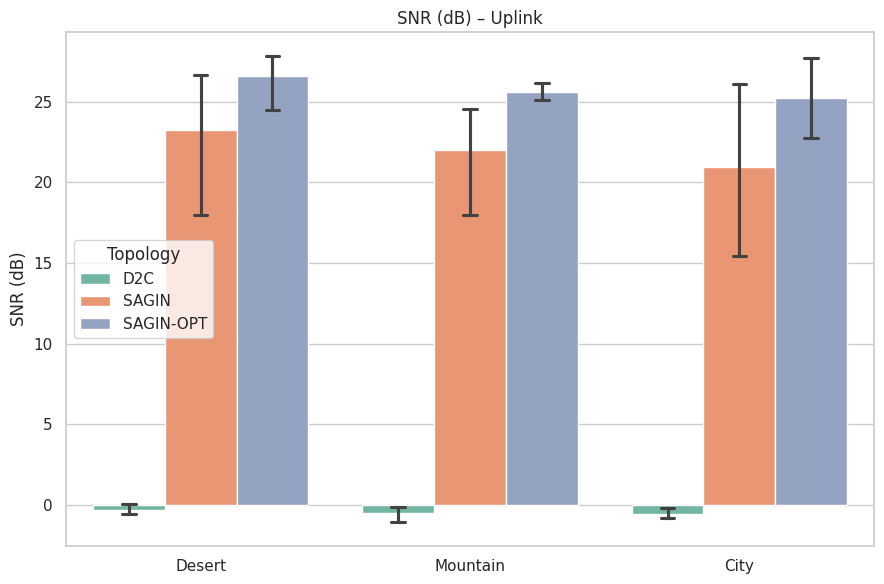

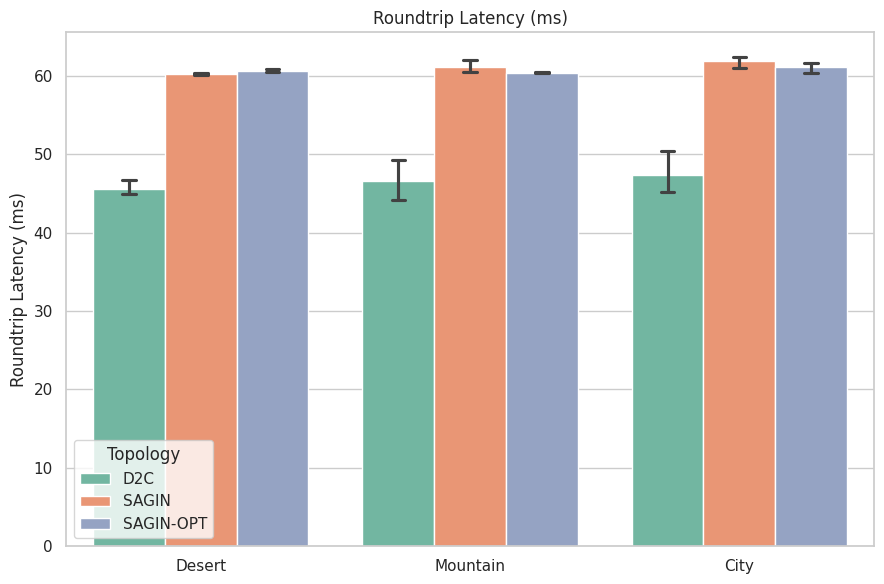

In [3]:
# Evaluate Placements
def best_uav_xyz(env, scene, n_trials=30):
    """
    Returns the (x, y, z) that maximizes mean SNR in 'downlink'
    for a given scene, using Optuna for optimization (silent and future-proof).
    """
    def objective(trial):
        x = trial.suggest_float("x", 0, area_size)
        y = trial.suggest_float("y", 0, area_size)
        z = trial.suggest_float("z", 100, 15e3)
        snrs = env.evaluate_sagin(np.array([x, y, z]), "downlink", scene)
        snrs = np.maximum(snrs, 1e-12)
        #return -np.mean(snrs)
        return -snrs.prod()**(1.0/len(snrs))

    # Silence logs
    optuna.logging.set_verbosity(optuna.logging.WARNING)

    study = optuna.create_study(direction="minimize")
    study.optimize(objective, n_trials=n_trials, show_progress_bar=False)

    best_xyz = np.array([
        study.best_params["x"],
        study.best_params["y"],
        study.best_params["z"]
    ])
    return best_xyz


# ────────────────────────────────  constants  ─────────────────────────────────
def M_of(mod):
    return {"bpsk":2, "qpsk":4, "16qam":16, "64qam":64, "256qam":256}[mod]

SCENES      = {"Desert": 2, "Mountain": 4, "City": 8}
DIRECT_MODS = {"Downlink": "16qam", "Uplink": "qpsk"}
SAGIN_MODS  = {"Downlink": "256qam", "Uplink": "16qam"}

# Named latency parameters
HARQ_time       = 8e-3          # seconds
proc_time       = 3e-3          # seconds
scheduling_time = 0.5e-3        # seconds
gw_time         = 5e-3          # seconds
speed_of_light  = 3e8           # m/s

block_size      = 1000 * 8      # bits per packet
area_size = 10e3
num_ut = 50
TRIALS = 3


# ───────────────────────────  main Monte‐Carlo loop  ───────────────────────────
records = []

for scene, extra_loss in SCENES.items():
    for t in range(TRIALS):
        print(t)
        # Initialize a RNG with seed = t for reproducibility
        rng = np.random.default_rng(t)

        # (1) random UAV location for the “SAGIN” case (instead of fixed center)
        #     x and y uniform in [0, area_size], z uniform in [2km, 15km]
        UAV_XYZ_fixed = np.array([
            rng.uniform(0, area_size),
            rng.uniform(0, area_size),
            rng.uniform(100, 15e3)
        ])

        # (2) draw UT positions
        ut_pos = rng.uniform(0, area_size, (num_ut, 2))

        # (3) draw a random antenna gain (dB) for each UT in [−3, 3]
        antenna_gains = rng.uniform(-3.0, 3.0, size=num_ut)

        env = SatUTDesertEnvSionna(ut_pos, ut_gains=antenna_gains, seed=t)

        # patch extra‐loss fields & missing SAGIN budget terms
        env.extra_losses     = extra_loss    # SAT→UE in D2C, UAV→UE in SAGIN
        env.extra_losses_sat = 0.0           # zero out SAT→UAV margin

        bw = env.bandwidth

        # (4) find best UAV position by Bayesian search (ignoring antenna gains for placement)
        UAV_XYZ_best = best_uav_xyz(env, scene, n_trials=40)

        for topo, evaluator, mod_dict in [
            ("D2C",      lambda d: env.evaluate(d, scene),                 DIRECT_MODS),
            ("SAGIN",    lambda d: env.evaluate_sagin(UAV_XYZ_fixed, d, scene), SAGIN_MODS),
            ("SAGIN-OPT",lambda d: env.evaluate_sagin(UAV_XYZ_best, d, scene),    SAGIN_MODS),
        ]:
            # Prepare a small dict to hold each direction’s one‐way latency (ms)
            lat_dict = {"Uplink": None, "Downlink": None}

            for dir_name, dir_key in [("Downlink", "downlink"), ("Uplink", "uplink")]:
                mod    = mod_dict[dir_name]
                snrs_linear = evaluator(dir_key)  # shape = (num_ut,)

                # Convert linear‐SNR → dB, add antenna gain per‐UT, convert back to linear
                snrs_clipped = np.maximum(snrs_linear, 1e-12)
                snr_db       = 10 * np.log10(snrs_clipped)
                snr_db_adj   = snr_db + antenna_gains
                snrs         = 10 ** (snr_db_adj / 10)

                ber_th = ber_theoretical(snrs, mod)
                exp    = 2 if dir_name == "Downlink" else 4
                bler   = np.mean([compute_bler(block_size, b_th**exp) for b_th in ber_th])

                phy_eff  = 0.79
                code_eff = 0.83 if M_of(mod) > 4 else 0.66
                raw_tp   = bw * np.log2(M_of(mod)) * phy_eff * code_eff
                eff_tp   = raw_tp * (1.0 - bler)

                if dir_name == "Downlink":
                    downlink_tp = eff_tp / 1e6  # Mbps
                    downlink_bler = bler
                elif dir_name == "Uplink":
                    uplink_tp = eff_tp / 1e6  # Mbps
                    uplink_bler = bler
                
                # Compute propagation to/from first UT only
                sat_xyz = np.array([area_size/2, area_size/2, env.alt_sat])
                ut_xyz  = np.hstack([ut_pos[0], env.alt_ut])
                prop    = np.linalg.norm(sat_xyz - ut_xyz) / speed_of_light

                # Now compute one‐way latency (in seconds, then convert → ms)
                if topo in ("SAGIN", "SAGIN-OPT"):
                    if dir_name == "Uplink":
                        # UE → UAV
                        lat_ms  = (scheduling_time + HARQ_time) * (1.0/(1.0 - bler)) + proc_time
                        # UAV → SAT
                        lat_ms += prop + HARQ_time + scheduling_time + gw_time + proc_time
                    else:
                        # SAT → UAV
                        lat_ms  = prop + HARQ_time + scheduling_time + gw_time + proc_time
                        # UAV → UE
                        lat_ms += (scheduling_time + HARQ_time) * (1.0/(1.0 - bler)) + proc_time
                else:  # "D2C"
                    lat_ms = (scheduling_time + HARQ_time) * (1.0/(1.0 - bler)) \
                             + gw_time + proc_time + prop

                
                # Convert one‐way seconds → milliseconds
                lat_ms *= 1e3
                if lat_ms > 500:
                    lat_ms = None

                lat_dict[dir_name] = lat_ms
                mean_snr_db = np.mean(snr_db_adj)
                records.append({
                    "Scene":     scene,
                    "Topology":  topo,
                    "Direction": dir_name,
                    "Metric":    "SNR (dB)",
                    "Value":     mean_snr_db
                })
                
                # Append throughput + BLER per direction
                records.append({
                    "Scene":     scene,
                    "Topology":  topo,
                    "Direction": dir_name,
                    "Metric":    "Effective Throughput (Mbps)",
                    "Value":     eff_tp / 1e6
                })
                records.append({
                    "Scene":     scene,
                    "Topology":  topo,
                    "Direction": dir_name,
                    "Metric":    "BLER",
                    "Value":     bler
                })

            # After both directions, form RTT if both are valid
            ul_lat = lat_dict["Uplink"]
            dl_lat = lat_dict["Downlink"]
            if (ul_lat is None) or (dl_lat is None):
                rtt_ms = None
            else:
                rtt_ms = ul_lat + dl_lat

            # Append exactly one RTT row per topology
            records.append({
                "Scene":     scene,
                "Topology":  topo,
                # no "Direction" for RTT
                "Metric":    "Roundtrip Latency (ms)",
                "Value":     rtt_ms
            })

df = pd.DataFrame(records)

# Create a “Link” column that fuses Topology + Direction (for plotting)
df["Link"] = df["Topology"] + (
    "" if df["Direction"].isna().all() else " " + df["Direction"].fillna("")
)


# ─────────────────────────────  plotting  ──────────────────────────────────
sns.set(style="whitegrid", palette="Set2")  # non‐default “Set2” palette

output_dir = "plots"
os.makedirs(output_dir, exist_ok=True)

# (A) Effective Throughput & BLER: separate Downlink / Uplink plots
for metric in ["Effective Throughput (Mbps)", "BLER", "SNR (dB)"]:
    for dir_name in ["Downlink", "Uplink"]:
        plt.figure(figsize=(9, 6))
        sns.barplot(
            data = df[(df["Metric"] == metric) & (df["Direction"] == dir_name)],
            x    = "Scene",
            y    = "Value",
            hue  = "Topology",
            estimator = np.mean,
            errorbar  = ("ci", 95),
            capsize    = .15
        )
        plt.title(f"{metric} – {dir_name}")
        plt.ylabel(metric)
        plt.xlabel("")
        plt.tight_layout()

        safe = (
            metric
            .replace("/", "per")
            .replace(" ", "_")
            .replace("(", "")
            .replace(")", "")
        )
        filename = f"{safe}_{dir_name}.png"
        plt.savefig(os.path.join(output_dir, filename), dpi=300)
        plt.show()


# (B) Roundtrip Latency: single plot (no per‐direction split)
plt.figure(figsize=(9, 6))
sns.barplot(
    data = df[df["Metric"] == "Roundtrip Latency (ms)"],
    x    = "Scene",
    y    = "Value",
    hue  = "Topology",
    estimator = np.mean,
    errorbar  = ("ci", 95),
    capsize    = .15
)
plt.title("Roundtrip Latency (ms)")
plt.ylabel("Roundtrip Latency (ms)")
plt.xlabel("")
plt.tight_layout()

safe = "Roundtrip_Latency_ms"
filename = f"{safe}.png"
plt.savefig(os.path.join(output_dir, filename), dpi=300)
plt.show()


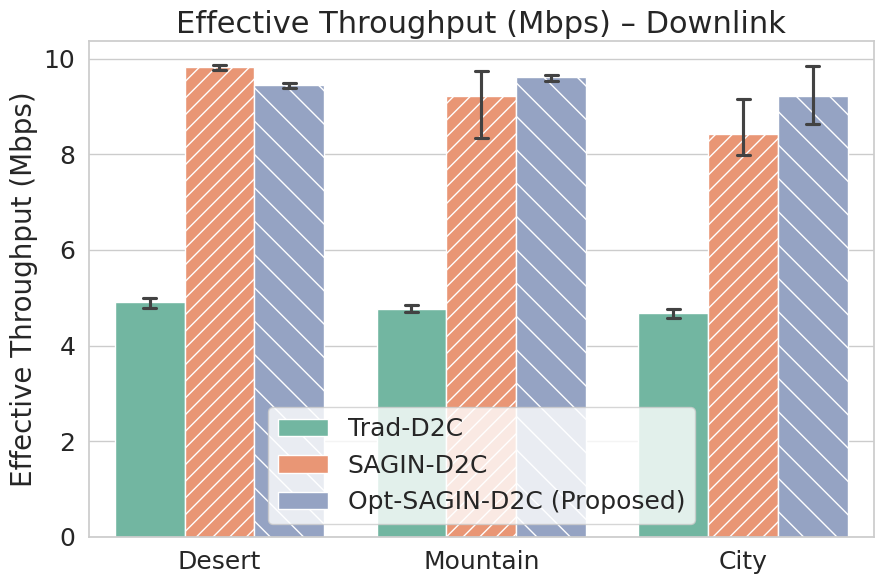

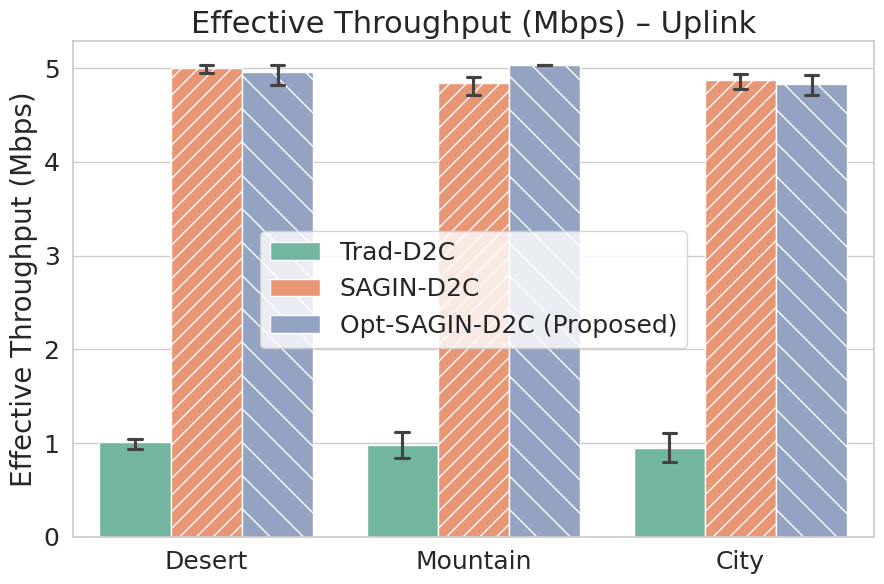

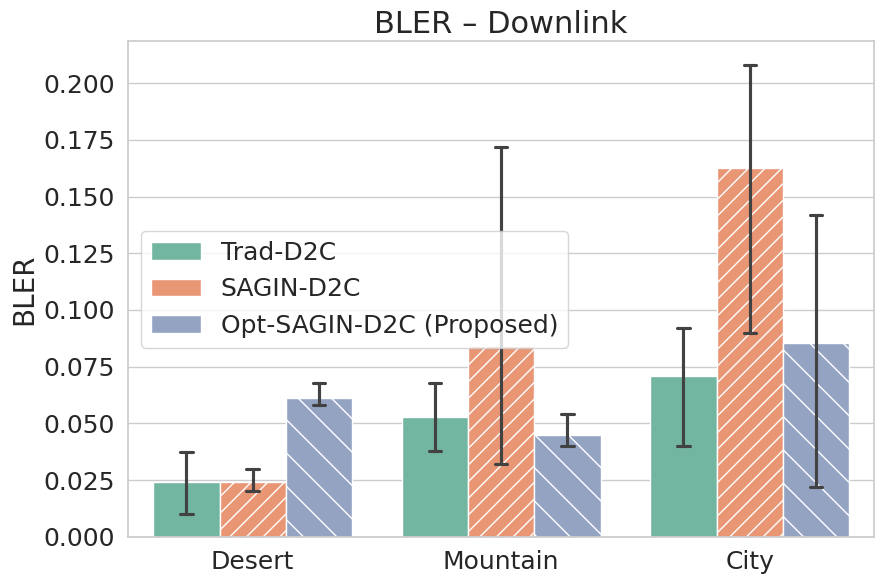

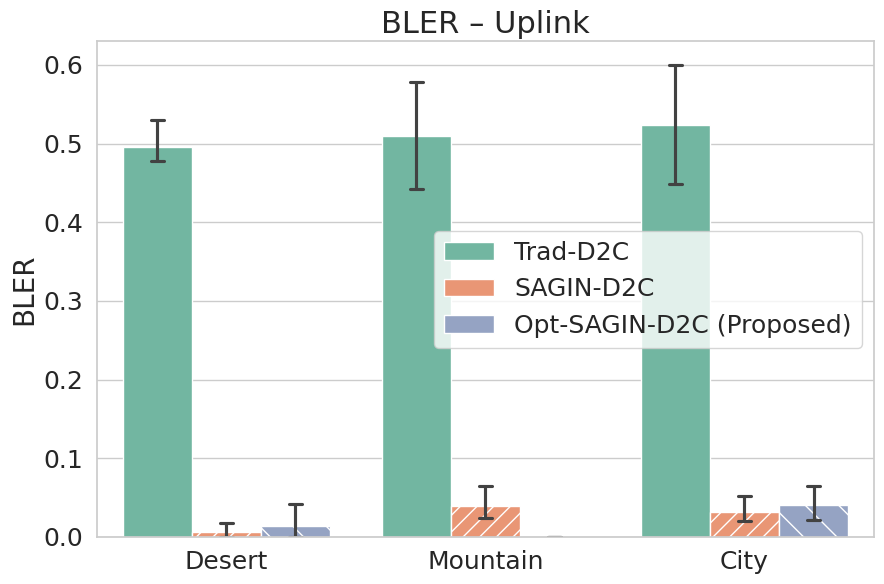

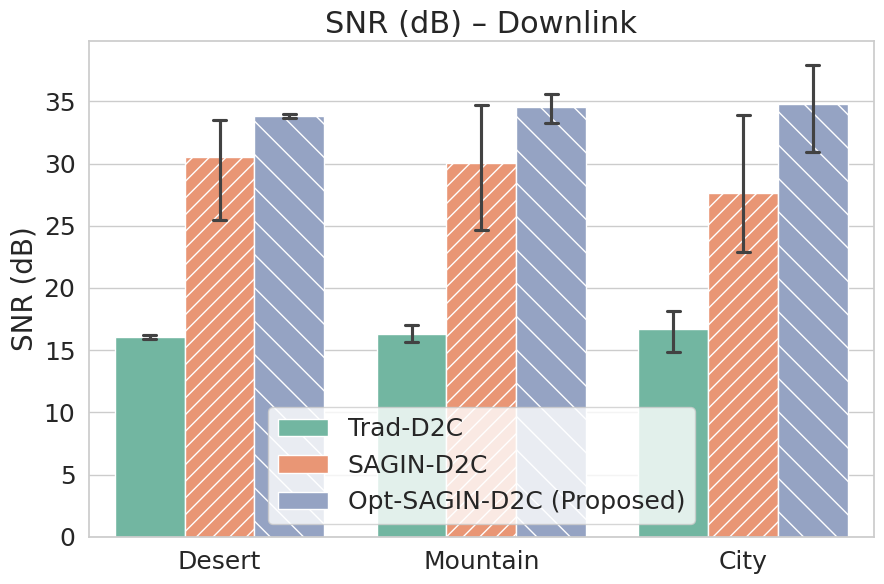

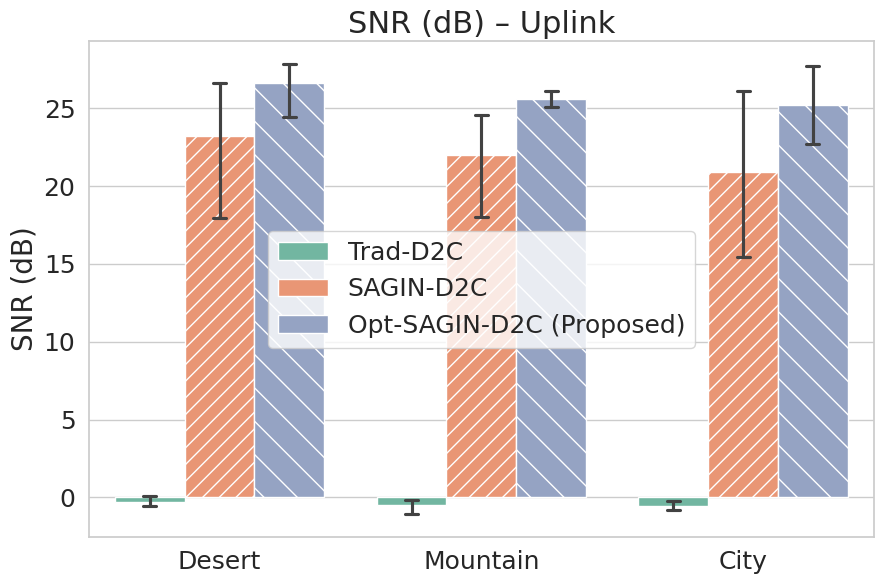

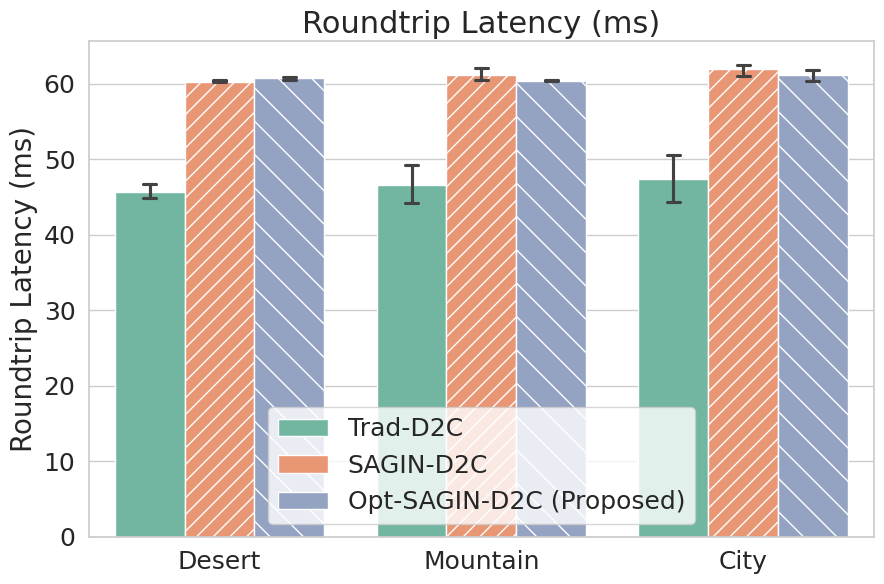

In [4]:
# Save to csv and plot the results.
output_dir = "results"
os.makedirs(output_dir, exist_ok=True)
csv_path = os.path.join(output_dir, "simulation_results.csv")
df.to_csv(csv_path, index=False)

# ───────────────────  Load the CSV for plotting  ───────────────────
df_loaded = pd.read_csv(csv_path)

# ─── Rename topologies so we know exactly what order to expect ───
df_loaded["Topology"] = df_loaded["Topology"].replace({
    "D2C": "Trad-D2C",
    "SAGIN": "SAGIN-D2C",
    "SAGIN-OPT": "Opt-SAGIN-D2C (Proposed)"
})

plt.rcParams.update({
    "axes.titlesize": 22,
    "axes.labelsize": 20,
    "xtick.labelsize": 18,
    "ytick.labelsize": 18,
    "legend.fontsize": 18
})
sns.set(style="whitegrid")
colors = "Set2"
# ─── Fix the exact hue order and give each a hatch string ─────────────────
hue_order     = ["Trad-D2C", "SAGIN-D2C", "Opt-SAGIN-D2C (Proposed)"]
#   • “Trad-D2C”      : no hatch ("")
#   • “SAGIN-D2C”     : "//"
#   • “Opt-SAGIN-D2C” : "\"  (escaped as "\\" in Python)
hatch_patterns = ["", "//", "\\"]
n_topos = len(hue_order)
# ────────────────────────────────────────────────────────────────────────

# A) Effective Throughput (separate Downlink / Uplink)
for metric in ["Effective Throughput (Mbps)", "BLER", "SNR (dB)"]:
    for dir_name in ["Downlink", "Uplink"]:
        plt.figure(figsize=(9, 6))
        ax = sns.barplot(
            data=df_loaded[
                (df_loaded["Metric"] == metric) &
                (df_loaded["Direction"] == dir_name)
            ],
            x="Scene",
            y="Value",
            hue="Topology",
            hue_order=hue_order,          # lock in the same 3-category order
            estimator=np.mean,
            errorbar=("ci", 95),
            capsize=0.15,
            palette=sns.color_palette(colors, n_colors=n_topos)
        )

        # Rather than idx % n_topos on ax.patches, grab each "container" (one per hue)
        for container, hatch in zip(ax.containers, hatch_patterns):
            for bar in container.patches:
                bar.set_hatch(hatch)

        plt.title(f"{metric} – {dir_name}", fontsize=22)
        plt.ylabel(metric, fontsize=20)
        plt.xlabel("", fontsize=20)
        plt.xticks(fontsize=18)
        plt.yticks(fontsize=18)
        plt.legend(fontsize=18)
        plt.tight_layout()

        safe = (
            metric
            .replace("/", "per")
            .replace(" ", "_")
            .replace("(", "")
            .replace(")", "")
        )
        filename = f"{safe}_{dir_name}.pdf"
        plt.savefig(os.path.join(output_dir, filename), dpi=300)
        plt.show()

# B) Roundtrip Latency (single plot)
plt.figure(figsize=(9, 6))
ax = sns.barplot(
    data=df_loaded[df_loaded["Metric"] == "Roundtrip Latency (ms)"],
    x="Scene",
    y="Value",
    hue="Topology",
    hue_order=hue_order,
    estimator=np.mean,
    errorbar=("ci", 95),
    capsize=0.15,
    palette=sns.color_palette(colors, n_colors=n_topos)
)

for container, hatch in zip(ax.containers, hatch_patterns):
    for bar in container.patches:
        bar.set_hatch(hatch)

plt.title("Roundtrip Latency (ms)", fontsize=22)
plt.ylabel("Roundtrip Latency (ms)", fontsize=20)
plt.xlabel("", fontsize=20)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.legend(fontsize=18)
plt.tight_layout()

safe = "Roundtrip_Latency_ms"
filename = f"{safe}.pdf"
plt.savefig(os.path.join(output_dir, filename), dpi=300)
plt.show()